# Program 3.01: Visualization of the issue regarding the increase of neighbours over five realizations

## Preamble

In [ ]:
using NBInclude

In [ ]:
@nbinclude("preamble/packages.ipynb");

In [ ]:
@nbinclude("preamble/functions.ipynb");

In [ ]:
model = ABM(3,

	# Global parameters
	model = Dict(
		# Physical constants
		:range => Float64,
		:lambda => Float64,
		:mu => Float64,
		:adh => Array{Float64},
        :rep => Float64,
		# Division constants
		:tau_div => Float64,
		:sigma_div => Float64,
		:olap => Float64,
		:g_on => Bool,
		:d_on => Bool,
		:b => Float64,
		:p => Float64,
		:q => Float64,
		:k => Float64,
		# Noise parameters
		:fp => Float64,
		:kp_on => Float64,
		:kp_off => Float64,
		# Reference values
		:t0 => Float64,
		:r0 => Float64,
		:f0 => Float64,
	),


	# Local parameters
	agent = Dict(
		:t_div => Float64,
		:ni => Int64,
		:cell_state => Int64,
		# :m=>Float64,               
		:r => Float64,
		:vx => Float64,
		:vy => Float64,
		:vz => Float64,
		:vsumx => Float64,
		:vsumy => Float64,
		:vsumz => Float64,
		:fx => Float64,
		:fy => Float64,
		:fz => Float64,
		:ni_a => Float64,
		:r_ab => Float64,
		:r_bc => Float64,
		# Noise
		:fpx => Float64,
		:fpy => Float64,
		:fpz => Float64,
		:marked => Bool,
		:t_paired => Float64,
	), 
	
	
	agentODE = quote
		# Physical dynamics
		fx = 0
		fy = 0
		fz = 0
		vsumx = 0
		vsumy = 0
		vsumz = 0
		ni = 0
		@loopOverNeighbors it2 begin
			dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
			if dij < mu * 2 * r && dij > 0
				fx += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (x - x[it2]) / dij
				fy += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (y - y[it2]) / dij
				fz += adh[cell_state, cell_state[it2]] * (2 * r / dij - 1) * (mu * 2 * r / dij - 1) * (z - z[it2]) / dij
				vsumx += vx[it2]
				vsumy += vy[it2]
				vsumz += vz[it2]
			end
			if dij < range * 2 * r
				ni += 1
			end
		end
		if marked == true
			if t < t_paired
				fx += fpx
				fy += fpy
				fz += fpz
			else
				marked = false
			end
		end

		lambda_i = lambda
		if ni != 0
			lambda_i *= ni
		end
		vx = fx / lambda_i # if ni = 0 then f = 0 too
		vy = fy / lambda_i
		vz = fz / lambda_i

		dt(x) = vx
		dt(y) = vy
		dt(z) = vz
	end, 
	
	
	agentRule = quote
		# Growth
		if g_on
			if t > t_div
				x_div = CBMDistributions.normal(0, 1)
				y_div = CBMDistributions.normal(0, 1)
				z_div = CBMDistributions.normal(0, 1)
				norm_div = sqrt(x_div^2 + y_div^2 + z_div^2)
				x_div /= norm_div
				y_div /= norm_div
				z_div /= norm_div

				r_sep = r * olap
				@addAgent(
					x = x + r_sep * x_div,
					y = y + r_sep * y_div,
					z = z + r_sep * z_div,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@addAgent(
					x = x - r_sep * x_div,
					y = y - r_sep * y_div,
					z = z - r_sep * z_div,
					vx = vx / 2,
					vy = vy / 2,
					vz = vz / 2,
					t_div = t + CBMDistributions.uniform(tau_div * (1 - sigma_div), tau_div * (1 + sigma_div))
				)
				@removeAgent()
			end
		end

		# State evolution
		if d_on == true && cell_state != 3
			ni = 0
			ni_a = 0
			@loopOverNeighbors it2 begin
				dij = CBMMetrics.euclidean(x, x[it2], y, y[it2], z, z[it2])
				if dij < range * 2 * r
					ni += 1
					if (cell_state[it2] == 1)
						ni_a += 1
					end
				end
			end

			if ni != 0
				ni_a /= ni
			end

			ran = CBMDistributions.uniform(0, 1)

			if cell_state == 1
				r_ab = p / (1 + k * ni_a)
				if ran < r_ab * dt
					cell_state = 2
				end

			elseif cell_state == 2
				r_bc = q / (1 + k * ni_a)
				if ran < r_bc * dt
					cell_state = 3
				end
			end
		end

	end, 
	
	
	agentAlg = CBMIntegrators.Heun(),
);


In [ ]:
function find_instance(com, n)

	return minimum([i for i in 1:length(com) if com[i].N > n])

end;


## Initialization

In [ ]:
parameters = define_par(lambda = 0.1);

dt = 0.001;
save_each = round(Int64, 0.25 / dt);
n_cells = 1000;


## Aggregate

In [ ]:
Random.seed!(2345)
ite = 5

# coms = Dict{Any,Community}()
coms = Array{Community}(undef, ite);

In [ ]:
for i in 1:ite
	com = initialize_growth(parameters; dt=dt)
	grow_size!(com, save_each, n_cells)
	m0 = length(com)
	println(formed_correctly(com))
	plot_aggregate(com, color_map, 1, m0)
	coms[i] = com
end

## Analysis

In [ ]:
# mean of means
n_cells = 1000
x = (30:30:n_cells-1)
nx = length(x)
avgs_ni = Array{Vector{Float64}}(undef, ite)

for i in 1:ite
	avgs_ni[i] = [mean(coms[i][find_instance(coms[i], j)].ni) for j in x]
end

labelsize = 40
biglabelsize = 1.25 * labelsize;

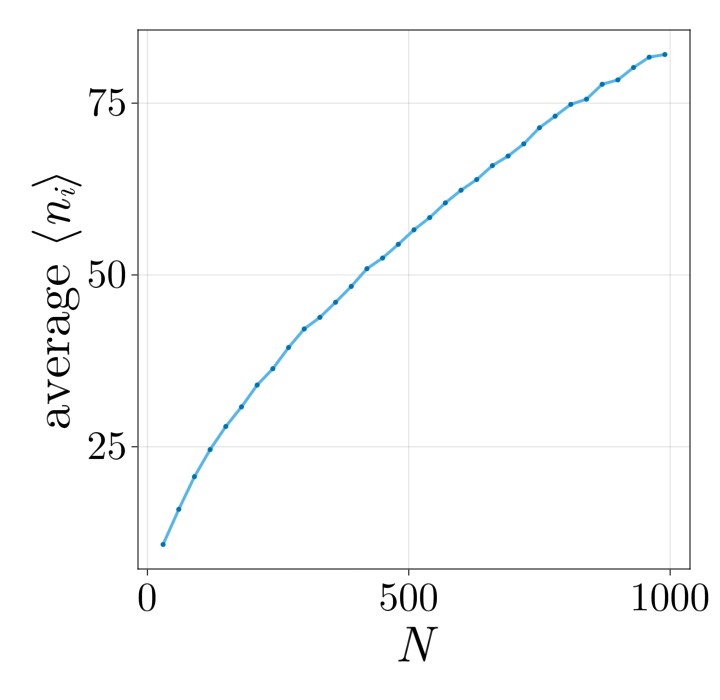

GLMakie.Screen(...)

In [43]:
mean_avgs_ni = Array{Float64}(undef, length(avgs_ni[1]))
for i in 1:5
	mean_avgs_ni .+= avgs_ni[i]
end
mean_avgs_ni /= ite;


# plotting

fig = Figure(resolution = (720, 700), figure_padding = 30)
ax = Axis(fig[1, 1], xlabel = L"N", ylabel = L"$\text{average }\langle n_i \rangle$",
	xlabelsize = biglabelsize, ylabelsize = biglabelsize, xticklabelsize = labelsize, yticklabelsize = labelsize)

lines!(ax, x, mean_avgs_ni, color = Makie.wong_colors()[5], linewidth = 3)
scatter!(ax, x, mean_avgs_ni, color = Makie.wong_colors()[1], markersize = 7)

display(fig)

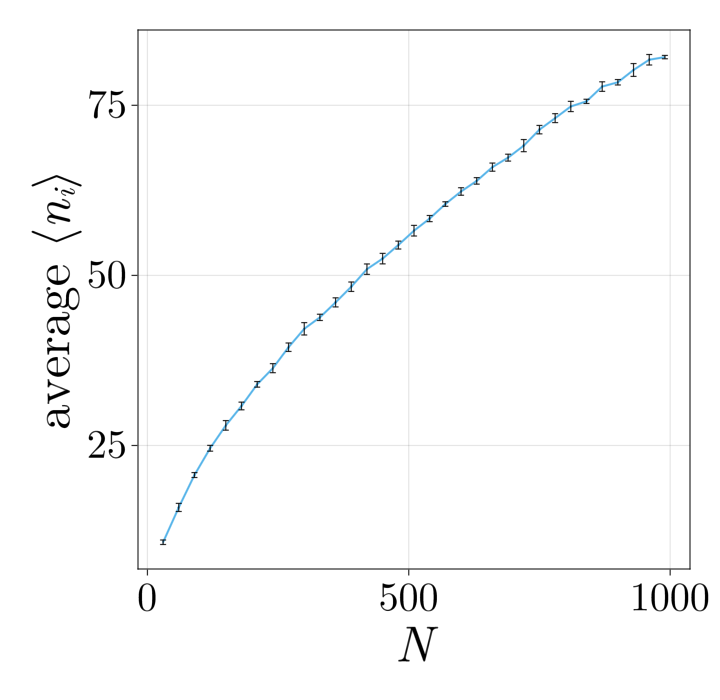

0.07427319917297409

In [45]:
mean_avgs_ni = Array{Float64}(undef, nx)

for i in 1:5
	mean_avgs_ni .+= avgs_ni[i]
end
mean_avgs_ni /= ite

std_avgs_ni = Array{Float64}(undef, nx)
for i in 1:nx
	std_avgs_ni[i] = std([avgs_ni[j][i] for j in 1:5])
end

fig = Figure(resolution = (720, 700), figure_padding = 30)
ax = Axis(fig[1, 1], xlabel = L"N", ylabel = L"$\text{average }\langle n_i \rangle$",
	xlabelsize = biglabelsize, ylabelsize = biglabelsize, xticklabelsize = labelsize, yticklabelsize = labelsize)
ylim = maximum(mean_avgs_ni)

lines!(ax, x, mean_avgs_ni, color = Makie.wong_colors()[5], linewidth = 2)
scatter!(ax, x, mean_avgs_ni, color = Makie.wong_colors()[1], markersize = 1)
errorbars!(ax, x, mean_avgs_ni, std_avgs_ni, std_avgs_ni,
	color = :black, whiskerwidth = 6, linewidth = 1)

display(fig)

# mean slope
mean((mean_avgs_ni[i] - mean_avgs_ni[i-1]) / (x[i] - x[i-1]) for i in 2:length(x))


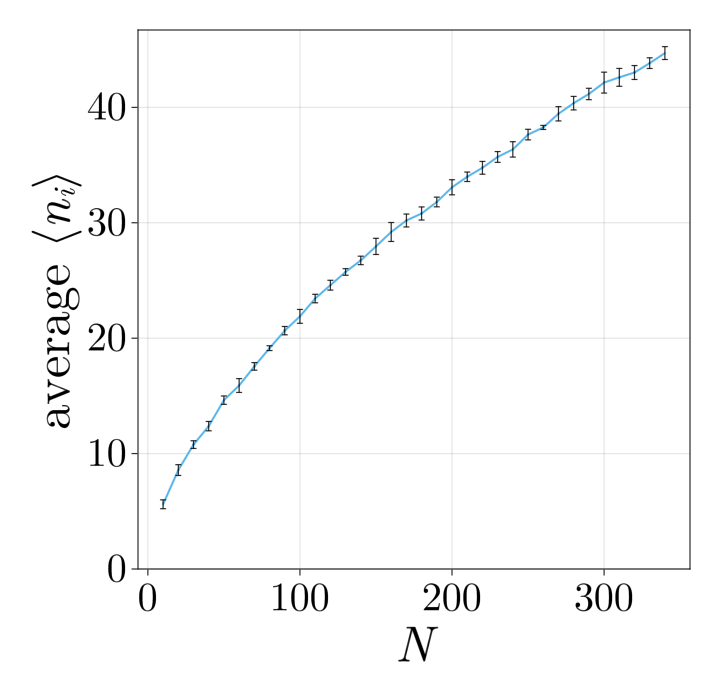

0.11847798201173552

In [46]:
# mean of means
n_cells = 350
x = (10:10:n_cells-1)
nx = length(x)
avgs_ni = Array{Vector{Float64}}(undef, ite)

for i in 1:ite
	avgs_ni[i] = [mean(coms[i][find_instance(coms[i], j)].ni) for j in x]
end

mean_avgs_ni = Array{Float64}(undef, nx)

for i in 1:5
	mean_avgs_ni .+= avgs_ni[i]
end
mean_avgs_ni /= ite

std_avgs_ni = Array{Float64}(undef, nx)
for i in 1:nx
	std_avgs_ni[i] = std([avgs_ni[j][i] for j in 1:5])
end

fig = Figure(resolution = (720, 700), figure_padding = 30)
ax = Axis(fig[1, 1], xlabel = L"N", ylabel = L"$\text{average }\langle n_i \rangle$",
	xlabelsize = biglabelsize, ylabelsize = biglabelsize, xticklabelsize = labelsize, yticklabelsize = labelsize)
ylim = maximum(mean_avgs_ni)
ylims!(ax, 0, ylim + 2)

lines!(ax, x, mean_avgs_ni, color = Makie.wong_colors()[5], linewidth = 2)
scatter!(ax, x, mean_avgs_ni, color = Makie.wong_colors()[1], markersize = 1)
errorbars!(ax, x, mean_avgs_ni, std_avgs_ni, std_avgs_ni,
	color = :black, whiskerwidth = 6, linewidth = 1)

display(fig)

# mean slope
mean((mean_avgs_ni[i] - mean_avgs_ni[i-1]) / (x[i] - x[i-1]) for i in 2:length(x))
